<a href="https://colab.research.google.com/github/Babitha23/Cyberbullying-detection/blob/main/xlnet_model_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import tensorflow as tf

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
!pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 7.5 MB/s 
     |████████████████████████████████| 880 kB 71.9 MB/s 
     |████████████████████████████████| 1.3 MB 29.8 MB/s 
     |████████████████████████████████| 132 kB 49.1 MB/s 
     |████████████████████████████████| 10.2 MB 5.0 MB/s 
     |████████████████████████████████| 79 kB 2.2 MB/s 
     |████████████████████████████████| 140 kB 62.9 MB/s 
     |████████████████████████████████| 127 kB 64.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=6e6c24e6bab3933ddc9499cf121f2f4b95943e9644f4b160fe250f9dc7343efc
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

from keras_preprocessing.sequence import pad_sequences
from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
from google.colab import drive
# Connect to google drive
drive.mount('/content/gdrive')

# Load data and set labels
data = pickle.load(open('gdrive/My Drive/Dissertation/formspring_data.pkl', 'rb'))
df = pd.DataFrame(data)

Mounted at /content/gdrive


In [ ]:
df.head()

,text,label
0,what is your favorite song ? d i like too many...,0
1,3 3 ? haha jk ! 33,0
2,hey angel you duh sexy really ? ! ? ! thanks ?...,0
3,,0
4,meowww rawr ?,0


###Test train split

In [ ]:
from sklearn.model_selection import train_test_split
df_main, df_test = train_test_split(df, test_size=0.1, random_state=101)

In [ ]:
df_main.label.value_counts()

0    10792
1      703
Name: label, dtype: int64

In [ ]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11495 entries, 6851 to 1547
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11495 non-null  object
 1   label   11495 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 269.4+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1278 entries, 5557 to 7067
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1278 non-null   object
 1   label   1278 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 30.0+ KB


In [ ]:
# Get the lists of sentences and their labels.
sentences = df_main.text.values
labels = df_main.label.values

We need to add special tokens ("[SEP]" and "[CLS]") at the beginning and end of each sentence for XLNet to work properly.

For BERT, the special token pattern looks like this:

[CLS] + Sentence_A + [SEP] + Sentence_B + [SEP]

Whereas with XLNet the token pattern looks like this:

Sentence_A + [SEP] + Sentence_B + [SEP] + [CLS]

For single sentence inputs here, we just need to add [SEP] and [CLS] to the end:

In [ ]:
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]

In [ ]:
sentences[0]

'what do you think of america ? r just a thought i could grow to like it i think i mean i havent been yet but im def making a trip d [SEP] [CLS]'

Next, import the XLNet tokenizer, used to convert our text into tokens that correspond to XLNet's vocabulary.

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 798011/798011 [00:00<00:00, 2564745.60B/s]


Tokenize the first sentence:
['▁what', '▁do', '▁you', '▁think', '▁of', '▁', 'america', '▁', '?', '▁', 'r', '▁just', '▁a', '▁thought', '▁', 'i', '▁could', '▁grow', '▁to', '▁like', '▁it', '▁', 'i', '▁think', '▁', 'i', '▁mean', '▁', 'i', '▁haven', 't', '▁been', '▁yet', '▁but', '▁im', '▁def', '▁making', '▁a', '▁trip', '▁', 'd', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


XLNet requires specifically formatted inputs. For each tokenized input sentence, we need to create:

input ids: a sequence of integers identifying each input token to its index number in the XLNet tokenizer vocabulary
segment mask: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
attention mask: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
labels: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

In [ ]:
# Set the maximum sequence length. We'll leave room on the end anyway. 
MAX_LEN = 512

In [ ]:
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create the attention masks 

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)


In [ ]:
print(len(train_inputs))
print(len(validation_inputs))

10345
1150


In [ ]:
print(len(train_masks))
print(len(validation_masks))

10345
1150


In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)


In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 8

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Train model

Now that our input data is properly formatted, it's time to fine tune the XLNet model.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.5 MB/s 
     |████████████████████████████████| 7.6 MB 46.4 MB/s 
     |████████████████████████████████| 182 kB 71.0 MB/s 


In [ ]:
from transformers import XLNetForSequenceClassification

In [ ]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
model.cuda()

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

At each pass we need to:

Training loop:

Tell the model to compute gradients by setting the model in train mode
Unpack our data inputs and labels
Load data onto the GPU for acceleration
Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
Forward pass (feed input data through the network)
Backward pass (backpropagation)
Tell the network to update parameters with optimizer.step()
Track variables for monitoring progress
Evalution loop:

Tell the model not to compute gradients by setting th emodel in evaluation mode
Unpack our data inputs and labels
Load data onto the GPU for acceleration
Forward pass (feed input data through the network)
Compute loss on our validation data and track variables for monitoring progress

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import gc
gc.collect()

34

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  458500 KB |  458500 KB |  458500 KB |       0 B  |\n|       from large pool |  457984 KB |  457984 KB |  457984 KB |       0 B  |\n|       from small pool |     516 KB |     516 KB |     516 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |  458500 KB |  458500 KB |  458500 KB |       0 B  |\n|       from large pool |  457984 KB |  457984 KB |

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()
 
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss: 0.1911287662053878


Epoch:  25%|██▌       | 1/4 [34:22<1:43:08, 2062.85s/it]

Validation Accuracy: 0.9513888888888888
Train loss: 0.149387129800541


Epoch:  50%|█████     | 2/4 [1:08:43<1:08:43, 2061.59s/it]

Validation Accuracy: 0.9618055555555556
Train loss: 0.12045265544314582


Epoch:  75%|███████▌  | 3/4 [1:43:04<34:21, 2061.48s/it]  

Validation Accuracy: 0.9609375
Train loss: 0.09292198117600914


Epoch: 100%|██████████| 4/4 [2:17:26<00:00, 2061.64s/it]

Validation Accuracy: 0.9539930555555556


In [ ]:
torch.save(model, "gdrive/My Drive/Dissertation/xlnetmodel")

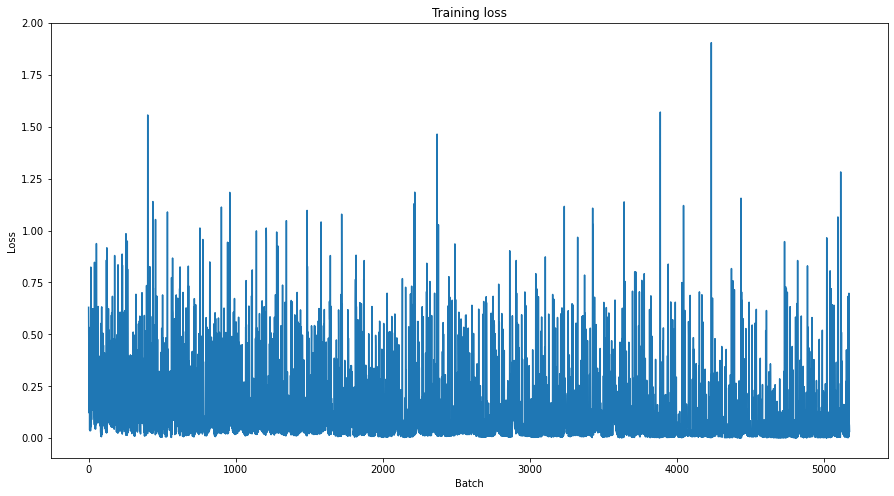

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# Prediction on test set

In [ ]:
t_sentences = df_test.text.values
t_labels = df_test.label.values

In [ ]:
t_sentences = [sentence + " [SEP] [CLS]" for sentence in t_sentences]


In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
t_tokenized_texts = [tokenizer.tokenize(sent) for sent in t_sentences]

# Set the maximum sequence length.
MAX_LEN = 512

# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
t_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in t_tokenized_texts]
# Pad our input tokens
t_input_ids = pad_sequences(t_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
t_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in t_input_ids:
  seq_mask = [float(i>0) for i in seq]
  t_attention_masks.append(seq_mask)
  
 # Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

In [ ]:
test_inputs = torch.tensor(t_input_ids)
test_labels = torch.tensor(t_labels)
test_masks = torch.tensor(t_attention_masks)

In [ ]:
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
model = torch.load("gdrive/My Drive/Dissertation/xlnetmodel")

In [ ]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [ ]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [ ]:
matthews_set

In [ ]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.515029779539909

Accuracy: 95.62%
F1 score: 51.72%
Precision: 69.77%
Recall: 41.10%
Accuracy 0.96


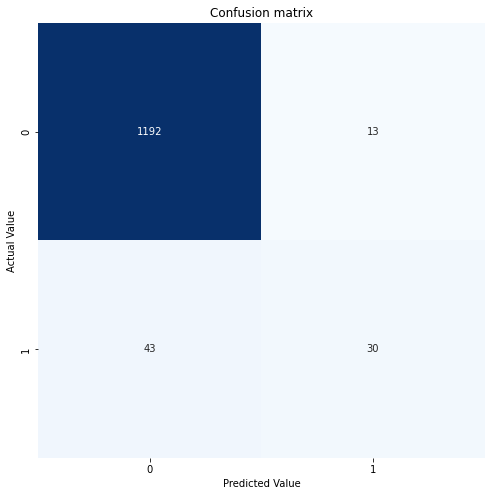

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1205
           1       0.70      0.41      0.52        73

    accuracy                           0.96      1278
   macro avg       0.83      0.70      0.75      1278
weighted avg       0.95      0.96      0.95      1278



In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print(f'Accuracy: {accuracy*100:.2f}%')
f1 = f1_score(flat_true_labels, flat_predictions)
print(f'F1 score: {f1*100:.2f}%')
precision = precision_score(flat_true_labels, flat_predictions)
print(f'Precision: {precision*100:.2f}%')
recall = recall_score(flat_true_labels, flat_predictions)
print(f'Recall: {recall*100:.2f}%')

c_matrix =confusion_matrix(flat_true_labels,flat_predictions)
clr = classification_report(flat_true_labels,flat_predictions)
accuracy = accuracy_score(flat_true_labels, flat_predictions)
print("Accuracy", round(accuracy,2) )
plt.figure(figsize=(8,8))
sns.heatmap(c_matrix,annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.title("Confusion matrix")
plt.show()
print(clr)

AUC: 0.7001


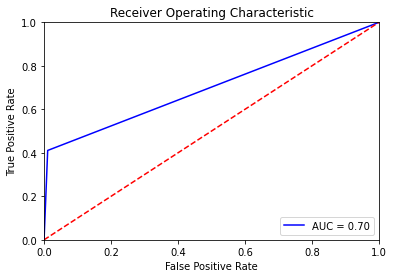

In [ ]:
fpr, tpr, threshold = roc_curve(flat_true_labels,flat_predictions)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()